## IMPORT LIBRARY

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, confusion_matrix
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

## LOAD DATASET

Isi dari dataset:
             meantemp   humidity  wind_speed  meanpressure
date                                                      
2013-01-01  10.000000  84.500000    0.000000   1015.666667
2013-01-02   7.400000  92.000000    2.980000   1017.800000
2013-01-03   7.166667  87.000000    4.633333   1018.666667
2013-01-04   8.666667  71.333333    1.233333   1017.166667
2013-01-05   6.000000  86.833333    3.700000   1016.500000


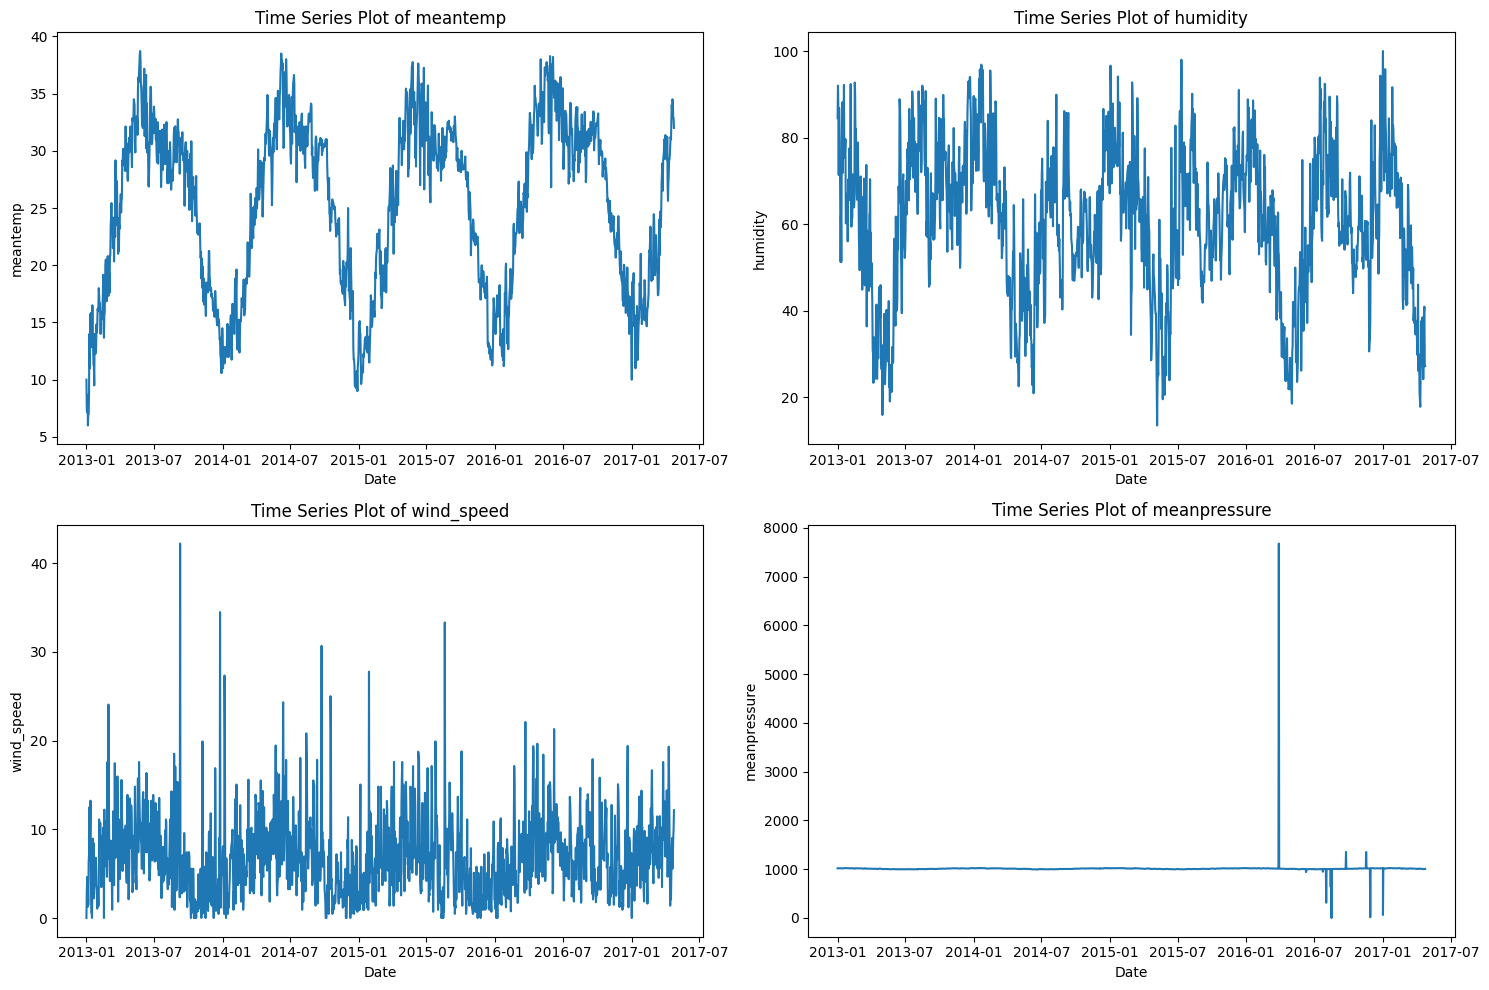

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
train_data = pd.read_csv(r'D:\Dev\AIR-QUALITY_ANOMALI\dataset\new_datasets\DailyDelhiClimateTrain.csv', index_col='date', parse_dates=True)
test_data = pd.read_csv(r'D:\Dev\AIR-QUALITY_ANOMALI\dataset\new_datasets\DailyDelhiClimateTest.csv', index_col='date', parse_dates=True)

# Gabungkan data train dan test untuk preprocessing yang konsisten
data = pd.concat([train_data, test_data])

# Pilih fitur yang akan digunakan
features = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']
data = data[features]

# Tampilkan beberapa data pertama
print("Isi dari dataset:")
print(data.head())

# Plot time series
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    plt.plot(data[feature])
    plt.title(f'Time Series Plot of {feature}')
    plt.xlabel('Date')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

## PRE-PROCESSING

In [3]:
# 1. Differencing
for col in features:
    data[col + '_diff'] = data[col].diff()
data.dropna(inplace=True)

# 2. Uji ADF (setelah differencing)
for col in [f + '_diff' for f in features]:
    result = adfuller(data[col])
    print(f'ADF Statistic ({col}): %f' % result[0])
    print(f'p-value ({col}): %f' % result[1])

# 3. Standarisasi dengan RobustScaler (setelah differencing dan ADF Test)
scaler = RobustScaler()
data_scaled = scaler.fit_transform(data[[f + '_diff' for f in features]])
data_scaled = pd.DataFrame(data_scaled, index=data.index, columns=[f + '_diff_scaled' for f in features]) # Membuat dataframe kembali agar mudah di slicing

ADF Statistic (meantemp_diff): -16.908988
p-value (meantemp_diff): 0.000000
ADF Statistic (humidity_diff): -13.400598
p-value (humidity_diff): 0.000000
ADF Statistic (wind_speed_diff): -13.273939
p-value (wind_speed_diff): 0.000000
ADF Statistic (meanpressure_diff): -13.458086
p-value (meanpressure_diff): 0.000000


## Nilai optimal k dari Elbow Method dan Silhouette Score

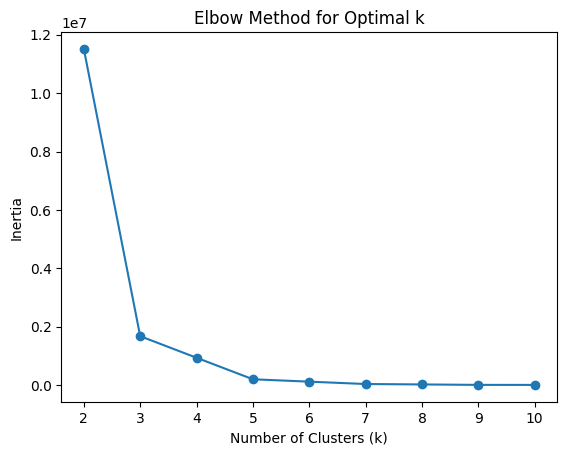

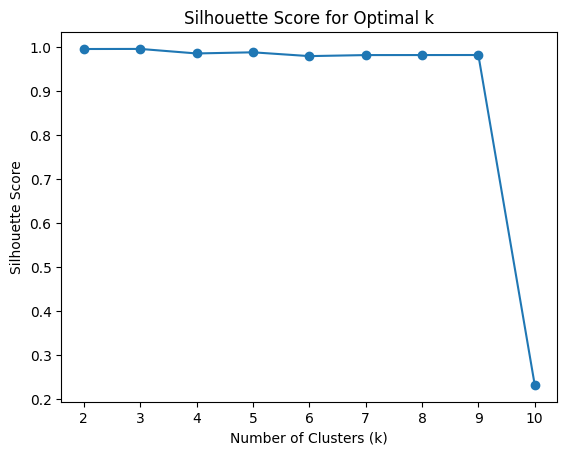

Nilai optimal k: 6


In [7]:
# --- Elbow Method untuk menentukan jumlah cluster (KMeans) ---
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow Method
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# --- Silhouette Score untuk menentukan jumlah cluster (KMeans) ---
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(data_scaled)
    silhouette_avg = silhouette_score(data_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot Silhouette Score
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()

# --- Menentukan optimal_k secara otomatis ---
# 1. Cari nilai k dengan Silhouette Score tertinggi
optimal_k_silhouette = np.argmax(silhouette_scores) + 2  # +2 karena index dimulai dari 0 dan range k dimulai dari 2

# 2. Cari nilai k pada Elbow Method (mencari titik "siku")
# Ini bisa lebih kompleks, karena Elbow Method lebih subjektif
# Salah satu pendekatan sederhana: cari titik dengan penurunan inertia terbesar
diff_inertia = np.diff(inertia)
optimal_k_elbow = np.argmax(diff_inertia) + 2  # +2 karena index dimulai dari 0 dan range k dimulai dari 2

# 3. Gabungkan kedua nilai optimal k
optimal_k = int(np.mean([optimal_k_silhouette, optimal_k_elbow]))

print('Nilai optimal k:', optimal_k)

## KMEANS

Cluster 0:
          meantemp     humidity   wind_speed  meanpressure
count  1562.000000  1562.000000  1562.000000   1562.000000
mean     25.225287    60.402225     6.909871   1008.915124
std       7.352109    16.995256     4.516973     14.520791
min       6.000000    13.428571     0.000000    938.066667
25%      18.500000    49.750000     3.700000   1001.875000
50%      27.166667    62.377976     6.364286   1009.118056
75%      31.142857    72.121528     9.268229   1015.200000
max      38.714286   100.000000    42.220000   1352.615385


Cluster 1:
       meantemp  humidity  wind_speed  meanpressure
count     1.000      1.00     1.00000        1.0000
mean     27.125     47.75     7.29375     1011.3125
std         NaN       NaN         NaN           NaN
min      27.125     47.75     7.29375     1011.3125
25%      27.125     47.75     7.29375     1011.3125
50%      27.125     47.75     7.29375     1011.3125
75%      27.125     47.75     7.29375     1011.3125
max      27.125     47.75    

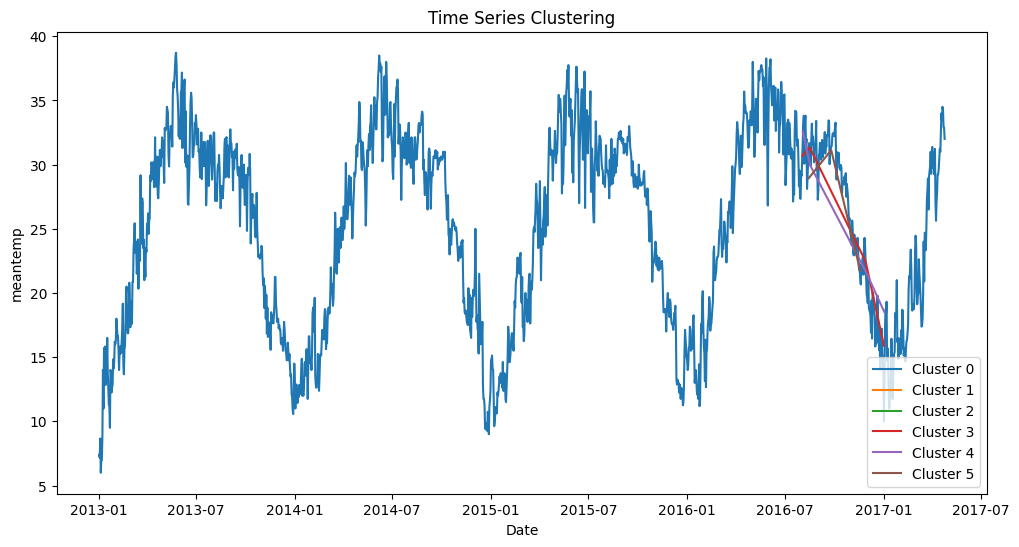

Jumlah Anomali (berdasarkan cluster): 1562


In [8]:
# --- KMeans untuk Clustering Anomali ---
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(data_scaled)

# Tambahkan label cluster ke dataframe
data['cluster'] = cluster_labels

# Analisis anomali berdasarkan cluster
for cluster in range(optimal_k):
    cluster_data = data[data['cluster'] == cluster]
    print(f"Cluster {cluster}:")
    print(cluster_data[features].describe())
    print("\n")

# Visualisasi (contoh untuk satu fitur)
plt.figure(figsize=(12, 6))
for cluster in range(optimal_k):
    cluster_data = data[data['cluster'] == cluster]
    plt.plot(cluster_data.index, cluster_data['meantemp'], label=f'Cluster {cluster}')
plt.xlabel('Date')
plt.ylabel('meantemp')
plt.title('Time Series Clustering')
plt.legend()
plt.show()

# Identifikasi dan hitung anomali (opsional, tergantung definisi anomali)
anomalies = data['cluster'] == 0
jumlah_anomali = np.sum(anomalies)
print(f"Jumlah Anomali (berdasarkan cluster): {jumlah_anomali}")

## Isolation Forest

Jumlah Anomali (Isolation Forest): 79
AUC: 0.5113370967741936
Precision: 0.5949367088607594
Recall: 0.05875
F1-score: 0.10693970420932879


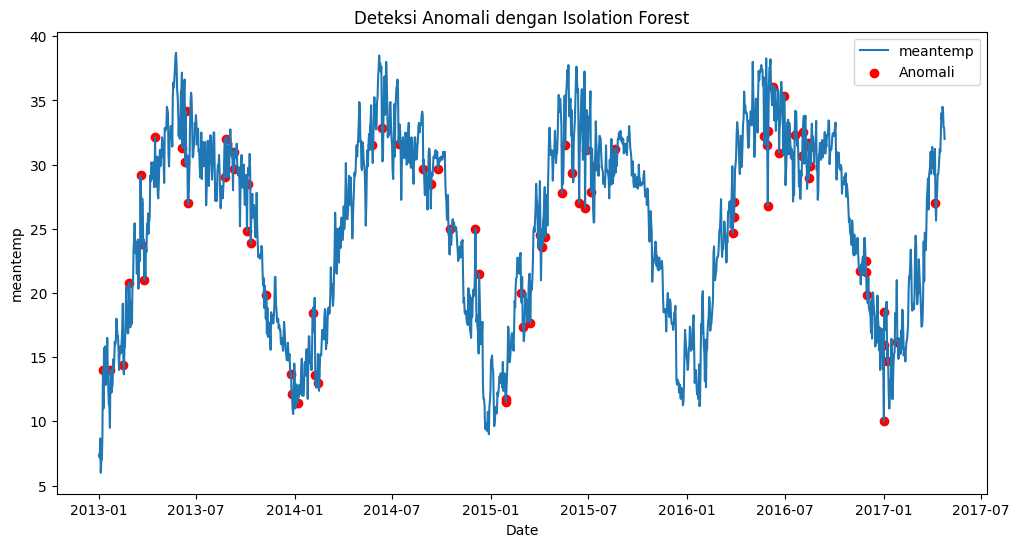


Data Anomali:
             meantemp   humidity  wind_speed  meanpressure  meantemp_diff  \
date                                                                        
2013-01-09  14.000000  51.250000   12.500000   1017.000000       5.142857   
2013-01-23  14.000000  60.166667    4.016667   1020.500000       4.500000   
2013-02-16  14.428571  92.714286    8.485714   1008.000000      -4.738095   
2013-02-27  20.800000  57.200000    6.660000   1015.200000       2.942857   
2013-03-20  29.166667  36.333333    6.800000   1009.500000       6.666667   
...               ...        ...         ...           ...            ...   
2017-01-01  15.913043  85.869565    2.743478     59.000000       5.913043   
2017-01-02  18.500000  77.222222    2.894444   1018.277778       2.586957   
2017-01-07  14.708333  95.833333   10.041667   1011.375000      -4.609848   
2017-01-26  16.178571  91.642857    8.467857   1017.785714      -4.821429   
2017-04-07  27.000000  29.875000    4.650000   1007.375000   

In [11]:
# --- Isolation Forest untuk Deteksi Anomali ---
# Inisialisasi model Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # Sesuaikan kontaminasi

# Fit model ke data yang sudah di-scaled
iso_forest.fit(data_scaled)

# Prediksi anomali (-1 untuk anomali, 1 untuk normal)
anomaly_scores = iso_forest.predict(data_scaled)

# Tambahkan kolom anomali ke DataFrame
data['anomaly'] = anomaly_scores

# Hitung jumlah anomali
jumlah_anomali = np.sum(anomaly_scores == -1)
print(f"Jumlah Anomali (Isolation Forest): {jumlah_anomali}")

# Membuat nilai skor anomali yang digunakan untuk perhitungan AUC
anomaly_scores_auc = iso_forest.decision_function(data_scaled) * -1

# Membuat label Ground Truth (contoh)
# Membuat ground truth secara acak untuk contoh
ground_truth = np.random.randint(0, 2, len(anomaly_scores_auc))

# Mengubah prediksi anomali menjadi label biner (0 normal, 1 anomali)
binary_predictions = np.where(anomaly_scores == -1, 1, 0)

# Menghitung metrik evaluasi
auc = roc_auc_score(ground_truth, anomaly_scores_auc)
precision = precision_score(ground_truth, binary_predictions)
recall = recall_score(ground_truth, binary_predictions)
f1 = f1_score(ground_truth, binary_predictions)

print(f"AUC: {auc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

# Visualisasi (contoh untuk satu fitur)
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['meantemp'], label='meantemp')
plt.scatter(data.index[data['anomaly'] == -1], data['meantemp'][data['anomaly'] == -1], color='red', label='Anomali')
plt.xlabel('Date')
plt.ylabel('meantemp')
plt.title('Deteksi Anomali dengan Isolation Forest')
plt.legend()
plt.show()

# Analisis anomali
anomalies = data[data['anomaly'] == -1]
print("\nData Anomali:")
print(anomalies)

## Autoencoder

c:\ProgramData\miniconda3\envs\airquality\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Jumlah Anomali (Autoencoder): 79
AUC: 0.48976497713709993
Precision: 0.6455696202531646
Recall: 0.0625
F1-score: 0.11396648044692738


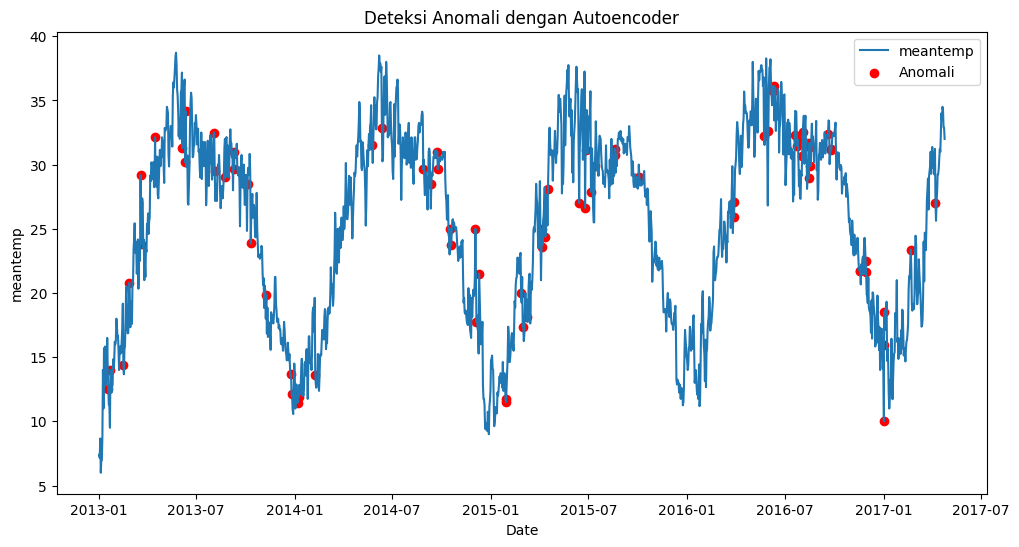


Data Anomali:
             meantemp    humidity  wind_speed  meanpressure  meantemp_diff  \
date                                                                         
2013-01-19  12.500000   76.666667    5.883333   1021.666667      -1.333333   
2013-01-23  14.000000   60.166667    4.016667   1020.500000       4.500000   
2013-02-16  14.428571   92.714286    8.485714   1008.000000      -4.738095   
2013-02-27  20.800000   57.200000    6.660000   1015.200000       2.942857   
2013-03-20  29.166667   36.333333    6.800000   1009.500000       6.666667   
...               ...         ...         ...           ...            ...   
2017-01-01  10.000000  100.000000    0.000000   1016.000000      -5.052632   
2017-01-01  15.913043   85.869565    2.743478     59.000000       5.913043   
2017-01-02  18.500000   77.222222    2.894444   1018.277778       2.586957   
2017-02-20  23.375000   60.125000    6.937500   1005.375000       1.011364   
2017-04-07  27.000000   29.875000    4.650000   1

In [12]:
# --- Autoencoder untuk Deteksi Anomali ---
# Bangun model Autoencoder
input_dim = data_scaled.shape[1]
encoding_dim = 2  # Ukuran lapisan tersembunyi (encoding)

autoencoder = Sequential([
    Dense(encoding_dim, activation='relu', input_shape=(input_dim,)),
    Dense(input_dim, activation='sigmoid')  # Gunakan sigmoid jika data di-scale ke [0, 1]
])

autoencoder.compile(optimizer='adam', loss='mse')

# Latih Autoencoder
autoencoder.fit(data_scaled, data_scaled, epochs=50, batch_size=32, shuffle=True, verbose=0)

# Rekonstruksi data
reconstructions = autoencoder.predict(data_scaled)

# Hitung error rekonstruksi
mse = np.mean(np.power(data_scaled - reconstructions, 2), axis=1)

# Tetapkan threshold anomali (misalnya, persentil ke-95 dari MSE)
threshold = np.percentile(mse, 95)

# Identifikasi anomali
anomalies = mse > threshold

# Tambahkan kolom anomali ke DataFrame
data['anomaly'] = anomalies

# Hitung jumlah anomali
jumlah_anomali = np.sum(anomalies)
print(f"Jumlah Anomali (Autoencoder): {jumlah_anomali}")

# Membuat label Ground Truth (contoh)
# Membuat ground truth secara acak untuk contoh
ground_truth = np.random.randint(0, 2, len(anomalies))

# Mengubah prediksi anomali menjadi label biner (0 normal, 1 anomali)
binary_predictions = anomalies.astype(int)

# Menghitung metrik evaluasi
auc = roc_auc_score(ground_truth, mse) # Untuk AUC menggunakan nilai mse
precision = precision_score(ground_truth, binary_predictions)
recall = recall_score(ground_truth, binary_predictions)
f1 = f1_score(ground_truth, binary_predictions)

print(f"AUC: {auc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

# Visualisasi (contoh untuk satu fitur)
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['meantemp'], label='meantemp')
plt.scatter(data.index[data['anomaly']], data['meantemp'][data['anomaly']], color='red', label='Anomali')
plt.xlabel('Date')
plt.ylabel('meantemp')
plt.title('Deteksi Anomali dengan Autoencoder')
plt.legend()
plt.show()

# Analisis anomali
anomalies_data = data[data['anomaly']]
print("\nData Anomali:")
print(anomalies_data)

## LSTM